<h1> Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

<h1> Import, Explore, and Prepare data

**Task**: Import data

In [2]:
df = pd.read_csv("ACME-HappinessSurvey2020.csv")
print("The shape of the data is: ", df.shape)
df.head()

The shape of the data is:  (126, 7)


,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


<h3> Data dictionary

<br> Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
<br> X1 = my order was delivered on time
<br> X2 = contents of my order was as I expected
<br> X3 = I ordered everything I wanted to order
<br> X4 = I paid a good price for my order
<br> X5 = I am satisfied with my courier
<br> X6 = the app makes ordering easy for me

In [3]:
df.isna().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

**Outcome:** The is no NULL value in the data. So we will not use any `imputer`.

**Task:** Let us take a look at how many customers are HAPPY and how many are not

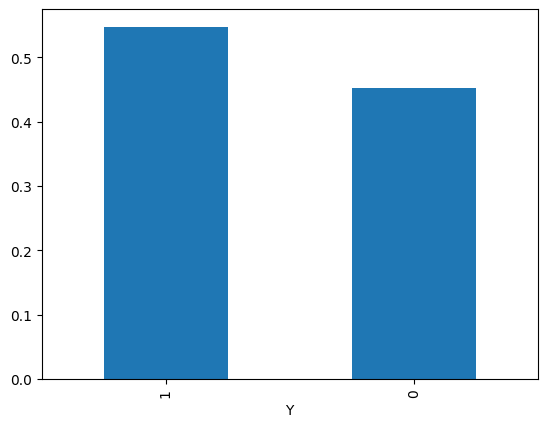

In [4]:
df["Y"].value_counts(normalize=True).plot(kind="bar");

In [5]:
(df["Y"].value_counts(normalize=True)*100).map(lambda x: f'{x:.2f}%')

Y
1    54.76%
0    45.24%
Name: proportion, dtype: object

**Outcome:** Our data is imbalanced. We will address the class imbalance using resampling the data using `Under sampling` and `over sampling`.

**Task:** Let us plot correlation heatmap of features in `df`. `"Y"` will be discluded because `"Y"` is our `target`.

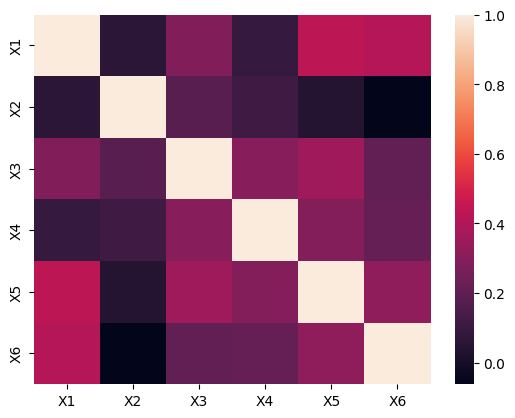

In [6]:
corr = df.drop(columns='Y').corr()
sns.heatmap(corr);

**Outcome:** We have autocorrelation issue, which means that we should steer clear of `linear model`, and try `tree-based` model instead.

**Task:** Create our feature matrix `X` and target vector `y`. Our target is `"Y"`.

In [7]:
X = df[["X1", "X2", "X3", "X4", "X5"]]
y = df["Y"]

print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (126, 5)
y.shape: (126,)


**Observation:** In order to make sure that our model can generalize, we need to put aside a test set that we'll use to evaluate out model once it's trained. 

**Task:** Divide the data (`X` and `y`) into training and test sets using a randomized train-test split. Let's take our validation set 20% of the total data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", X_test.shape)

X_train shape:  (100, 5)
X_test shape:  (26, 5)
y_train shape:  (100,)
y_test shape:  (26, 5)


<h1> Resampling

**Observation:** We can address the class imbalance by resampling the training data.

**Task:** Two strategis to resample data are under sampling and over sampling. Let us do that.

In [9]:
under_sampling = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampling.fit_resample(X_train, y_train)
print("X_train_under: ", X_train_under.shape)
print("y_train_under shape: ", y_train_under.shape)

X_train_under:  (84, 5)
y_train_under shape:  (84,)


c:\Users\Asraful Islam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Asraful Islam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [10]:
over_sampling = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampling.fit_resample(X_train, y_train)
print("X_train_under: ", X_train_over.shape)
print("y_train_under shape: ", y_train_over.shape)

X_train_under:  (116, 5)
y_train_under shape:  (116,)


c:\Users\Asraful Islam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Asraful Islam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


<h1> Build Model 
<h2> Baseline

**Task:** Let us calculate the baseline/minimum accuracy score for our model

In [11]:
acc_baseline = y_test.value_counts(normalize=True).max()*100
print(f"Baseline accuracy for trained data set: {round(acc_baseline, 4)}%")

Baseline accuracy for trained data set: 57.6923%


**Observation:** Now that we have a baseline, let's build a model to see if we can beat it.

<H2> DecisionTree Model

**Task:** Let's create three identical models: `model_dt_reg`, `model_dt_under`, and `model_dt_over` using `unaltered data`, `under sampled data`, and `over sampled data` respectively. We will use `DecsisionTreeClassifier`.

<h4> Decision tree fiting unaltered data set and calculating the accuracy score

In [12]:
model_dt_reg = DecisionTreeClassifier(random_state=42)
model_dt_reg.fit(X_train, y_train)
print(f"Decision Tree Model accuracy: {round(model_dt_reg.score(X_test, y_test)*100, 2)}%")

Decision Tree Model accuracy: 73.08%


<h4> Decision tree fiting over-sampled data set and calculating the accuracy score

In [13]:
model_dt_over = DecisionTreeClassifier(random_state=42)
model_dt_over.fit(X_train_over, y_train_over)
print(f"Decision Tree Model accuracy: {round(model_dt_over.score(X_test, y_test)*100, 2)}%")

Decision Tree Model accuracy: 73.08%


<h4> Decision tree fiting under-sampled data set and calculating the accuracy score

In [14]:
model_dt_under = DecisionTreeClassifier(random_state=42)
model_dt_under.fit(X_train_under, y_train_under)
print(f"Decision Tree Model accuracy: {round(model_dt_under.score(X_test, y_test)*100, 2)}%")

Decision Tree Model accuracy: 69.23%


**Observation:** Model using `unaltered data` has greater accuracy and beats the baseline accuracy. Looking at what the models got right or wrong, let's see how their prediction differs from for the two classes in the data.

**Task:** Plot confusion matrix that shows how best our models can predict

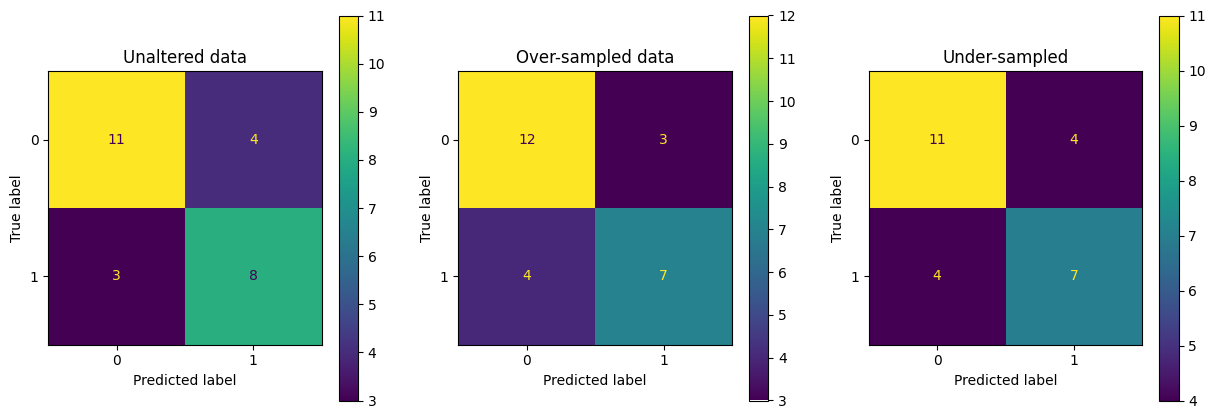

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the width and height

# Use correct indexing for a 1D array of axes
ConfusionMatrixDisplay.from_estimator(model_dt_reg, X_test, y_test, ax=axs[0])
axs[0].set_title('Unaltered data');
ConfusionMatrixDisplay.from_estimator(model_dt_over, X_test, y_test, ax=axs[1])
axs[1].set_title('Over-sampled data');
ConfusionMatrixDisplay.from_estimator(model_dt_under, X_test, y_test, ax=axs[2])
axs[2].set_title('Under-sampled');

**Outcome:** Predicting if a customer is HAPPY/UNHAPPY calculated using `unaltered data` is greater. But that doesn't ensure the model's performance when dealing with `imbalanced data`. So we move forward to using `randomforest model` with `hyper parameter tunning`.

<h2> Random Forest Model

So far, we've built single models that predict a single outcome. That's definitely a useful way to predict the future, but what if the one we built isn't the *right* one? If we could somehow use more that one model simultaneously, we'd have a more trustworthy prediction.

**Ensemble models** work by building multiple models on random subset of the same data, and then comparing their prediction to make a final prediction. SAince we used a decision tree in the last session, we're going to create an ensemble of trees here, called `random forest`.

Task: Create a pipeline named `clf` (short for "classifier") that contains a `RandomForestClassifier` predictor.

In [43]:
clf = make_pipeline(
    RandomForestClassifier(random_state=42))
clf

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

By default the number of trees in our forest (`n_estimators`) is set to 100. While it will take longer to train, it will hopefully lead to better performance.

In order to get the best performancefrom our model, we need to tune its `hyperparameter`. 

Task: Let's create a dictionary as the grids of `hyperparameters` that we want to evaluate for our classifier.

In [54]:
params = {
    "randomforestclassifier__n_estimators": range(20, 100, 20),
    "randomforestclassifier__max_depth": range(5, 50, 5)
}
params

{'randomforestclassifier__n_estimators': range(20, 100, 20),
 'randomforestclassifier__max_depth': range(5, 50, 5)}

TaskL: Let's create a `GridSearchCV` named `model` that includes our `classifier` and `hyperparameter grid`. 

In [55]:
model_RF = GridSearchCV(

    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model_RF

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 50, 5),
                         'randomforestclassifier__n_estimators': range(20, 100, 20)},
             verbose=1)

Task: Fit the `model` to the `unaltered`, `over-sampled`, and `under-dampled` data

In [56]:
def fit_model_RF (model, x, y):
    model.fit(x, y)

<h3> Training unaltered data using Random Forest Model with it's accuracy score 

In [58]:
fit_model_RF(model_RF, X_train, y_train)  
acc_rf_test = model_RF.score(X_test, y_test)*100

print(f"Random Forest Model accuracy: {round(acc_rf_test, 4)}%");

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Model accuracy: 61.5385%


<h3> Training over-sampled data using Random Forest Model with it's accuracy score 

In [57]:
fit_model_RF(model_RF, X_train_over, y_train_over)    
acc_rf_test = model_RF.score(X_test, y_test)*100

print(f"Random Forest Model accuracy: {round(acc_rf_test, 4)}%");

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Model accuracy: 73.0769%


<h3> Training under-sampled data using Random Forest Model with it's accuracy score 

In [59]:
fit_model_RF(model_RF, X_train_under, y_train_under)    
acc_rf_test = model_RF.score(X_test, y_test)*100

print(f"Random Forest Model accuracy: {round(acc_rf_test, 4)}%");

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Model accuracy: 73.0769%


Task: Extract the best `hyperparameters` from `model`

<h1> Evaluate our Model

Task: Calculate the accuracy score for `model`.

In [60]:
model_RF.best_estimator_

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=40,
                                        random_state=42))])

In [61]:
clf = make_pipeline(
    RandomForestClassifier(random_state=42))
params = {
    "randomforestclassifier__n_estimators": [5],
    "randomforestclassifier__max_depth": [40]
}
model_RF = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_RF.fit(X_train_over, y_train_over) 
acc_rf_train = model_RF.score(X_train, y_train)*100   
acc_rf_test = model_RF.score(X_test, y_test)*100

print(f"Random Forest Model accuracy train data: {round(acc_rf_train, 4)}%");
print(f"Random Forest Model accuracy test data: {round(acc_rf_test, 4)}%");


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest Model accuracy train data: 84.0%
Random Forest Model accuracy test data: 73.0769%


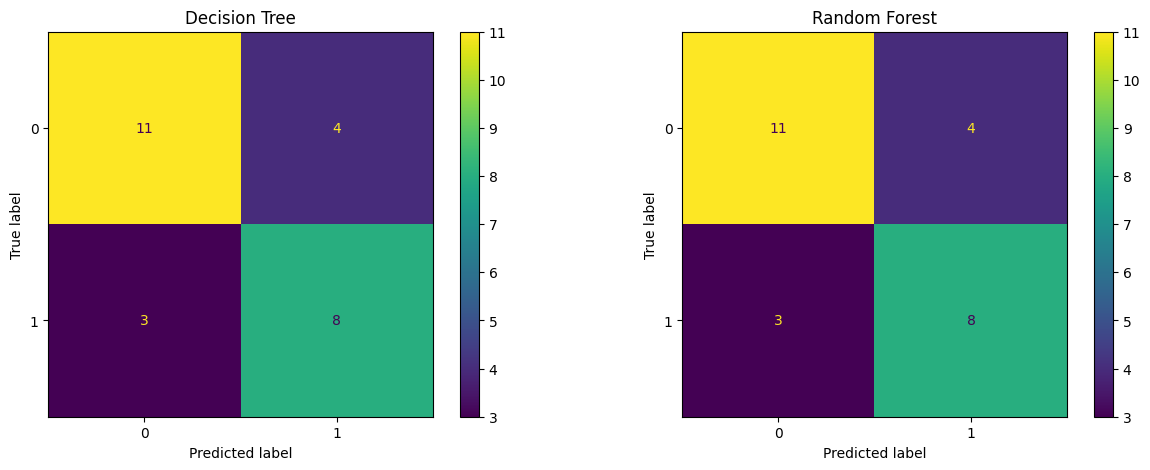

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the width and height

# Use correct indexing for a 1D array of axes
ConfusionMatrixDisplay.from_estimator(model_dt_reg, X_test, y_test, ax=axs[0])
axs[0].set_title('Decision Tree');

ConfusionMatrixDisplay.from_estimator(model_RF, X_test, y_test, ax=axs[1]);
axs[1].set_title('Random Forest');

**Outcome:** `Random Forest` beats the `Decision Tree` model with an accuracy score `65.38%`.

<h1> Communicate the result

**Task:** Create bar chart with the important features in order for the `Random Forest` model.

<Axes: >

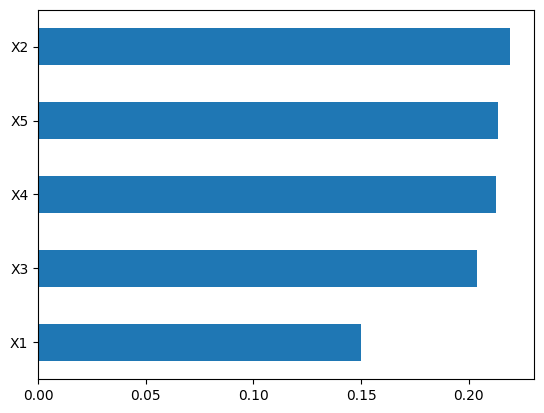

In [63]:
features = X_train_over.columns
importances = model_RF.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.plot(kind='barh')


In [64]:
feature_imp_df=pd.DataFrame(importances, index=features)
feature_imp_df = feature_imp_df.reset_index() 
feature_imp_df.columns = ["Feature", "Importance"]
feature_imp_df.sort_values(by="Importance", ascending=False)

,Feature,Importance
1,X2,0.219425
4,X5,0.213671
3,X4,0.212598
2,X3,0.204104
0,X1,0.150201


**Summary:** Our highest accuracy of **73.08%** in predicting customer happiness was achieved using both `Decision Tree` and ``Random Forest`` model. In our analysis, the most important feature was ``X2``, which reflects that the contents of their order was as they expected. Other features exhibited similar levels of importance.